# code to run runwise GLMs based on responses - main analysis: all social v. all nonsocial, its comparison with other S v. NS comparisons

In [1]:
# import general packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape # subs *movies

(1048, 10)

In [4]:
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_joined

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [5]:
print('Nr of completee subs:',len(np.where(np.array([len(np.where(~np.isnan(responses[s,:]))[0]) for s in range(responses.shape[0])])==10)[0]))
print('total subs:', responses.shape[0])

Nr of completee subs: 814
total subs: 1048


In [6]:
timecourses = np.load(os.path.join(data_file_loc,'timecourses.npy'))
timecourses.shape

(1048, 268, 269, 2)

In [7]:
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
vid_start_rel_tr

array([7, 14, 14, 14, 14, 7, 14, 14, 14, 14], dtype=object)

# GLM analysis

In [8]:
# function needed for the GLM
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool
from joblib import cpu_count
import time

In [9]:

# functions that will be parallelized across nodes. For use in the next cell

def lm_estimate(XY):
    # function to perform a linear regression and to return the reg. coefft.
    X = XY[:int(.5*len(XY))].reshape((-1,1))
    Y = XY[int(.5*len(XY)):] 
    model = LinearRegression().fit(X, Y) 
    return model.coef_[0] 


In [10]:
l_task = 28

In [16]:
load = 0 # 1 = load previously saved reg coeffts for all movies, 0 = estimate coefts freshly

0 time: 0.05942702293395996
100 time: 5.530480861663818
200 time: 11.484046936035156
300 time: 17.318342924118042
400 time: 23.327581882476807
500 time: 29.613464832305908
600 time: 34.96927094459534
700 time: 40.974862813949585
800 time: 46.41976189613342
900 time: 52.00445890426636
1000 time: 57.219704151153564


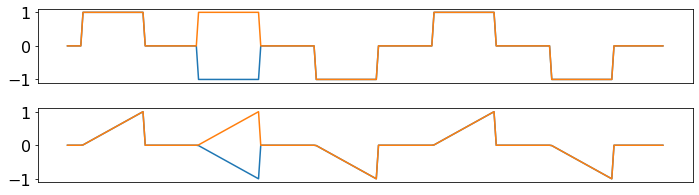

In [11]:
# Store block/slope regressors per run based on responses

if load == 0:
    coef_block = np.empty((timecourses.shape[0],268,2))
    coef_slope = np.empty_like(coef_block)
    coef_block[:] = np.nan
    coef_slope[:] = np.nan
    start = time.time()
    if __name__ == '__main__':
        pool = Pool(processes=cpu_count()) # helps to parallelize processing

        for s in range(timecourses.shape[0]):
            if s%100 ==0:
                print(s,'time:',time.time()-start) 
            if len(np.where(np.isnan(responses[s,:]))[0]) == 0: # if the subject responded to all stimuli (excluding incomeplete subs)
                for vid_no in range(10):
                    resp = responses[s,vid_no] # response for a subject and video nr.
                    inds = timepts_indiv_movie[vid_no][vid_start_rel_tr[vid_no]:vid_start_rel_tr[vid_no]+l_task]
                    if vid_no==0:
                        boxcar_run = np.zeros((269,2)) # to store runwise block regressors
                        slope_run = np.zeros_like(boxcar_run) # to store runwise slope regressors
                    
                    r = 1 if vid_no>=5 else 0
                    if resp == 1:
                        boxcar_run[inds,r] = 1 
                        slope_run[inds,r] = np.linspace(0.01,1,len(inds)) 
                    
                    elif resp == 0:
                        boxcar_run[inds,r] = -1
                        slope_run[inds,r] = -1*np.linspace(0.01,1,len(inds))
                    
                    if (s==1) and (vid_no ==9):
                        plt.figure(1,figsize=(10,3))
                        plt.subplot(211)
                        plt.plot(boxcar_run, label = 'block reg')
                        plt.xticks([])
                        plt.subplot(212)
                        plt.plot(slope_run, label = 'slope reg')
                        plt.xticks([])
                        plt.tight_layout()

                #for node in range(268):
                for r in range(2):
                    #Y = timecourses[s,node,:,r]
                    Y = timecourses[s,:,:,r] # nodes * ntimepts
                    
                    XY = np.hstack((np.tile(boxcar_run[:,r],(268,1)),Y))
                    #print(XY)
                    XY = [i for i in XY]
                    #X = boxcar_run[:,r].reshape((-1, 1))
                    coef_block[s,:,r] = pool.map(lm_estimate,XY)

                    XY = np.hstack((np.tile(slope_run[:,r],(268,1)),Y))
                    XY = [i for i in XY]
                    coef_slope[s,:,r] = pool.map(lm_estimate,XY)
    
    fileName = os.path.join(data_file_loc,f'coef_blockreg_all.npy')
    np.save(fileName,coef_block)
    fileName = os.path.join(data_file_loc,f'coef_slopereg_all.npy')
    np.save(fileName,coef_slope)

elif load == 1:
    fileName = os.path.join(data_file_loc,f'coef_blockreg_all.npy')
    coef_block = np.load(fileName)
    fileName = os.path.join(data_file_loc,f'coef_slopereg_all.npy')
    coef_slope = np.load(fileName)
    


<AxesSubplot:>

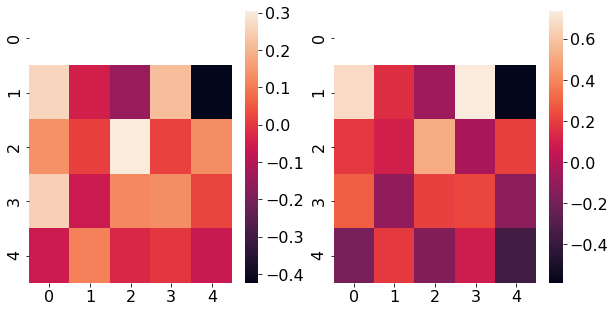

In [12]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)
sns.heatmap(coef_block[:5,:5,1])
plt.subplot(122)
sns.heatmap(coef_slope[:5,:5,1])

## Plot results

In [17]:
# functions to plot brain maps
#from nilearn.plotting import plot_glass_brain
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain   
from nilearn.plotting import plot_glass_brain
# multiple comparisons fdr correction
from mne.stats import fdr_correction

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)     

In [18]:
p1_all = np.empty((268,))
p2_all = np.empty((268,))
p1_all[:] = np.nan
p2_all[:] = np.nan
for n in range(268):
    _,p1_all[n] = stats.ttest_1samp(np.ndarray.flatten(coef_block[:,n,:]),0,nan_policy='omit')
    _,p2_all[n] = stats.ttest_1samp(np.ndarray.flatten(coef_slope[:,n,:]),0,nan_policy='omit')

_,p1_all = fdr_correction(p1_all,.05)
_,p2_all = fdr_correction(p2_all,.05)

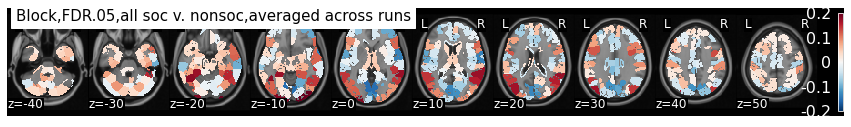

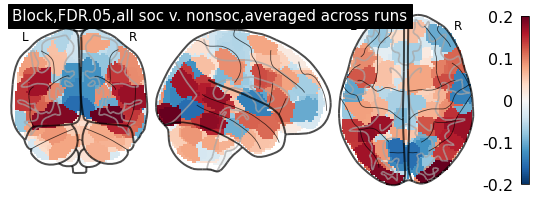

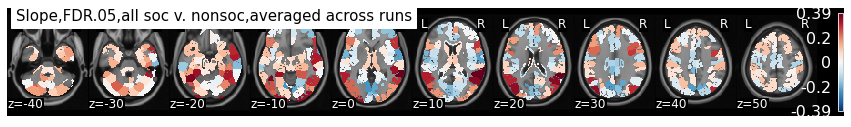

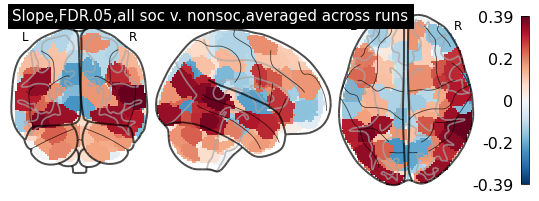

In [19]:
# block regressor, averaged across runs

nodes = np.zeros((268,))
nodes[p1_all<.05] = np.nanmean(coef_block,axis=(0,2))[p1_all<.05]
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = f'Block,FDR.05,all soc v. nonsoc,averaged across runs'
img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(), colorbar = True, title =  txt,plot_abs=False, cmap = 'RdBu_r')

# slope regressor, averaged across runs

nodes = np.zeros((268,))
nodes[p1_all<.05] = np.nanmean(coef_slope,axis=(0,2))[p1_all<.05]
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = f'Slope,FDR.05,all soc v. nonsoc,averaged across runs'
img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(), colorbar = True, title =  txt,plot_abs=False, cmap = 'RdBu_r')



SpearmanrResult(correlation=0.9742083617250616, pvalue=5.179850020268628e-174)

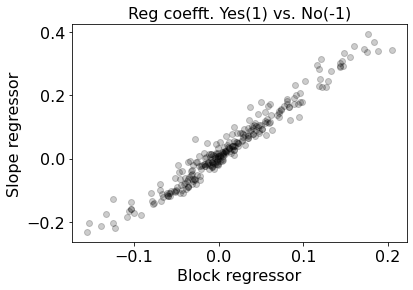

In [20]:
plt.plot(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_slope,axis=(0,2)),ls='None',marker = 'o',color='black',alpha = .2)
plt.xlabel('Block regressor')
plt.ylabel('Slope regressor')
plt.title('Reg coefft. Yes(1) vs. No(-1)')
stats.spearmanr(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_slope,axis=(0,2)))


# compare conditions

In [21]:
'''coef_block_rand = np.load(os.path.join(data_file_loc,'coef_blockreg_runnorm_Random mechanical.npy'))
coef_block_coax = np.load(os.path.join(data_file_loc,'coef_blockreg_trialnorm_COAXING-B.npy'))
coef_block_bill = np.load(os.path.join(data_file_loc,'coef_blockreg_trialnorm_BILLIARD-A.npy'))
coef_block_rand.shape'''

"coef_block_rand = np.load(os.path.join(data_file_loc,'coef_blockreg_runnorm_Random mechanical.npy'))\ncoef_block_coax = np.load(os.path.join(data_file_loc,'coef_blockreg_trialnorm_COAXING-B.npy'))\ncoef_block_bill = np.load(os.path.join(data_file_loc,'coef_blockreg_trialnorm_BILLIARD-A.npy'))\ncoef_block_rand.shape"

In [22]:
coef_slope_rand = np.load(os.path.join(data_file_loc,'coef_slopereg_runnorm_Random mechanical.npy'))
coef_slope_fish = np.load(os.path.join(data_file_loc,'coef_slopereg_runnorm_Fishing.npy'))
coef_slope_coax = np.load(os.path.join(data_file_loc,'coef_slopereg_trialnorm_COAXING-B.npy'))
coef_slope_bill = np.load(os.path.join(data_file_loc,'coef_slopereg_trialnorm_BILLIARD-A.npy'))
coef_slope_rand.shape

(1048, 268)

### All movies vs. Rand (block or slope)

 
1.779 x + 0.3259
slope: SpearmanrResult(correlation=0.41944780919761077, pvalue=7.619025117716986e-13)


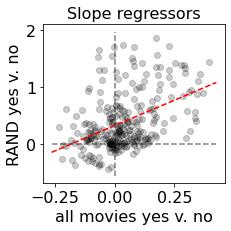

In [24]:
#fig = plt.figure(1,figsize=(7,3.5))
plt.figure(1,figsize=(3.5,3.5))
'''ax = fig.add_subplot(121)
(xmin,xmax) = (-.25,1)
(ymin,ymax) = (-.5,1.5)
#plt.subplot(121)
plt.plot(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_rand,axis=0),ls='None',marker = 'o',color='black',alpha = .2)
plt.xlabel('all movies yes v. no')
plt.ylabel('RAND yes v. no')
plt.title('Block regressors')
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'grey',ls = 'dashed')
xmin,xmax = plt.xlim()
plt.hlines(0,xmin,xmax,color = 'grey',ls = 'dashed')
m, b = np.polyfit(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_rand,axis=0), 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#ax.set_aspect('equal')

print('block:',stats.spearmanr(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_rand,axis=0)))

ax = fig.add_subplot(122)'''
#plt.subplot(122)
plt.plot(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_rand,axis=0),ls='None',marker = 'o',color='black',alpha = .2)
plt.xlabel('all movies yes v. no')
plt.ylabel('RAND yes v. no')
plt.title('Slope regressors')
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'grey',ls = 'dashed')
xmin,xmax = plt.xlim()
plt.hlines(0,xmin,xmax,color = 'grey',ls = 'dashed')
m, b = np.polyfit(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_rand,axis=0), 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')

print('slope:',stats.spearmanr(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_rand,axis=0)))

plt.tight_layout()


### All movies vs. Rand (block or slope)

 
2.708 x + 0.3638
slope: SpearmanrResult(correlation=0.6557320327895628, pvalue=2.5302809683779066e-34)


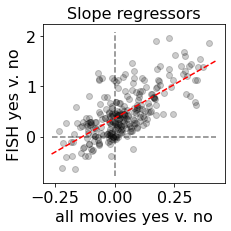

In [26]:
#fig = plt.figure(1,figsize=(7,3.5))
plt.figure(1,figsize=(3.5,3.5))
'''ax = fig.add_subplot(121)
(xmin,xmax) = (-.25,1)
(ymin,ymax) = (-.5,1.5)
#plt.subplot(121)
plt.plot(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_fish,axis=0),ls='None',marker = 'o',color='black',alpha = .2)
plt.xlabel('all movies yes v. no')
plt.ylabel('RAND yes v. no')
plt.title('Block regressors')
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'grey',ls = 'dashed')
xmin,xmax = plt.xlim()
plt.hlines(0,xmin,xmax,color = 'grey',ls = 'dashed')
m, b = np.polyfit(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_fish,axis=0), 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#ax.set_aspect('equal')

print('block:',stats.spearmanr(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_fish,axis=0)))

ax = fig.add_subplot(122)'''
#plt.subplot(122)
plt.plot(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_fish,axis=0),ls='None',marker = 'o',color='black',alpha = .2)
plt.xlabel('all movies yes v. no')
plt.ylabel('FISH yes v. no')
plt.title('Slope regressors')
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'grey',ls = 'dashed')
xmin,xmax = plt.xlim()
plt.hlines(0,xmin,xmax,color = 'grey',ls = 'dashed')
m, b = np.polyfit(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_fish,axis=0), 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')

print('slope:',stats.spearmanr(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_fish,axis=0)))

plt.tight_layout()


### All movies vs. coax/bill (block or slope)

 
0.818 x + 0.1226
SpearmanrResult(correlation=0.4413075177971717, pvalue=3.361313000847864e-14)


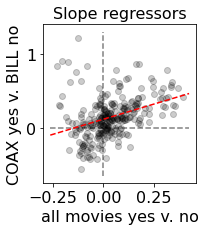

In [22]:
subs = (responses[:,0] == 1) & (responses[:,1]==0)

#plt.figure(1,figsize=(7,3.5))
plt.figure(1,figsize=(3.5,3.5))
'''plt.subplot(121)
plt.plot(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_coax[subs,:]-coef_block_bill[subs,:],axis=0),ls='None',
marker = 'o',color='black',alpha = .2)
plt.xlabel('all movies yes v. no')
plt.ylabel('COAX yes v. BILL no')
plt.title('Block regressors')
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'grey',ls = 'dashed')
xmin,xmax = plt.xlim()
plt.hlines(0,xmin,xmax,color = 'grey',ls = 'dashed')
m, b = np.polyfit(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_coax[subs,:]-coef_block_bill[subs,:],axis=0), 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
print(stats.spearmanr(np.nanmean(coef_block,axis=(0,2)),np.nanmean(coef_block_coax[subs,:]-coef_block_bill[subs,:],axis=0)))


plt.subplot(122)'''
plt.plot(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_coax[subs,:]-coef_slope_bill[subs,:],axis=0),ls='None',
marker = 'o',color='black',alpha = .2)
plt.xlabel('all movies yes v. no')
plt.ylabel('COAX yes v. BILL no')
plt.title('Slope regressors')
ymin,ymax = plt.ylim()
plt.vlines(0,ymin,ymax,color = 'grey',ls = 'dashed')
xmin,xmax = plt.xlim()
plt.hlines(0,xmin,xmax,color = 'grey',ls = 'dashed')
m, b = np.polyfit(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_coax[subs,:]-coef_slope_bill[subs,:],axis=0), 1)
print(np.poly1d([m,b]))
xplot = np.linspace(xmin,xmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
print(stats.spearmanr(np.nanmean(coef_slope,axis=(0,2)),np.nanmean(coef_slope_coax[subs,:]-coef_slope_bill[subs,:],axis=0)))

plt.tight_layout()

# comparing  between conditions

In [23]:
soc_inds = responses[:,4]==1
nonsoc_inds = responses[:,4]==0
_,pval_slope_rand = stats.ttest_ind(coef_slope_rand[soc_inds,:], coef_slope_rand[nonsoc_inds,:],axis=0, equal_var=False)
_,pval_slope_rand = fdr_correction(pval_slope_rand,.05)

meanDiff_sl_rand =  np.nanmean(coef_slope_rand[soc_inds,:],axis=0)-np.nanmean(coef_slope_rand[nonsoc_inds,:],axis=0)
meanDiff_sl_rand.shape

(268,)

In [35]:
_,pval_slope_paired = stats.ttest_rel(coef_slope_coax[subs,:], coef_slope_bill[subs,:],axis=0)
_,pval_slope_paired = fdr_correction(pval_slope_paired,.05)

meanDiff_sl_paired = np.nanmean(coef_slope_coax[subs,:,]-coef_slope_bill[subs,:],axis=0)
meanDiff_sl_paired.shape

(268,)

In [66]:
nodes_coaxbill_rand_all = (p2_all < .05) & (pval_slope_paired<.05) & (pval_slope_rand<.05) & \
(np.sign(meanDiff_sl_paired) == np.sign(meanDiff_sl_rand)) & (np.sign(meanDiff_sl_paired) == np.sign(np.nanmean(coef_block,axis=(0,2))))


(61,)

In [68]:
nodes = np.zeros((268,))
nodes[nodes_coaxbill_rand_all] = 1
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = 'Sig. (p<.05 FDR) nodes, slope reg., coax-bill and rand'
img.plot(title = txt,cmap='YlGn')
plot_glass_brain(img.to_nifti(), title=txt)



NameError: name 'mask_x' is not defined

# ** not too great an idea, so set aside for now /**

## Use whole-run regressors to compare (1) drif/fish/rand yes v. no, and (2) coax yes v. no

### DRIF/FISH/RAND: Store block/slope regressors per run based on responses



0 time: 0.10906505584716797
100 time: 12.675885200500488
200 time: 25.79878306388855
300 time: 39.29512405395508
400 time: 54.42031693458557
500 time: 67.83542513847351
600 time: 80.02427697181702
700 time: 92.13482713699341
800 time: 103.81355714797974
900 time: 115.54276609420776
1000 time: 127.21217799186707


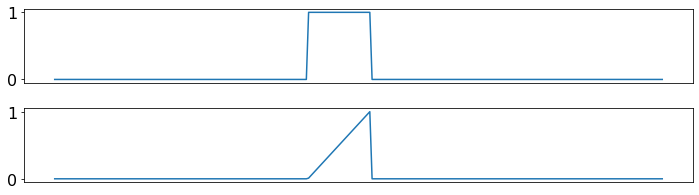

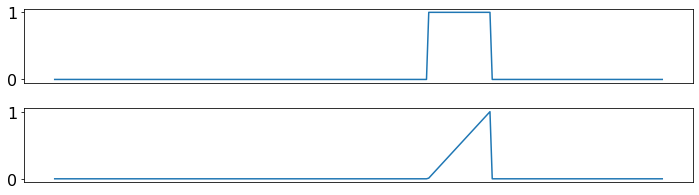

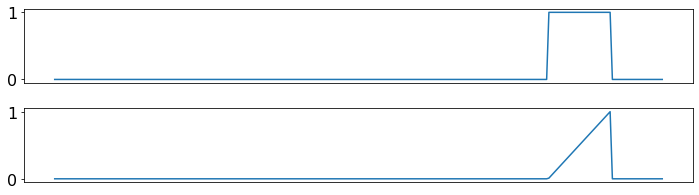

In [191]:
movies_ind = [2,3,4]
coef_block_run1_1movie = np.empty((timecourses.shape[0],268,len(movies_ind)))
coef_slope_run1_1movie = np.empty_like(coef_block_run1_1movie)
coef_block_run1_1movie[:] = np.nan
coef_slope_run1_1movie[:] = np.nan
start = time.time()
if __name__ == '__main__':
    pool = Pool(processes=cpu_count()) # helps to parallelize processing

    for s in range(timecourses.shape[0]): #RUN AGAIN!!
        if s%100 ==0:
            print(s,'time:',time.time()-start) 
        
        for i,vid_no in enumerate(movies_ind):
            resp = responses[s,vid_no] # response for a subject and video nr.
            
            inds = timepts_indiv_movie[vid_no][vid_start_rel_tr[vid_no]:vid_start_rel_tr[vid_no]+l_task]
            
            boxcar_run = np.zeros((269,)) # to store runwise block regressors
            slope_run = np.zeros_like(boxcar_run) # to store runwise slope regressors
            
            if (resp == 1) or (resp==0):
                boxcar_run[inds] = 1 
                slope_run[inds] = np.linspace(0.01,1,len(inds)) 
             
            if (s==1):
                plt.figure(i+1,figsize=(10,3))
                plt.subplot(211)
                plt.plot(boxcar_run, label = 'block reg')
                plt.xticks([])
                plt.subplot(212)
                plt.plot(slope_run, label = 'slope reg')
                plt.xticks([])
                plt.tight_layout()

            r = 1 if vid_no>=5 else 0
            Y = timecourses[s,:,:,0] # nodes * ntimepts
        
            XY = np.hstack((np.tile(boxcar_run,(268,1)),Y))
            #print(XY)
            XY = [ii for ii in XY]
            #X = boxcar_run[:,r].reshape((-1, 1))
            coef_block_run1_1movie[s,:,i] = pool.map(lm_estimate,XY)

            XY = np.hstack((np.tile(slope_run,(268,1)),Y))
            XY = [ii for ii in XY]
            coef_slope_run1_1movie[s,:,i] = pool.map(lm_estimate,XY)


#### stats + plot

In [207]:
# separately for runs

p1 = np.empty((268,len(movies_ind)))
p2 = np.empty_like(p1)
mean_diff1 = np.empty_like(p1)
mean_diff2 = np.empty_like(p1)
p1[:] = np.nan
p2[:] = np.nan
mean_diff1[:] = np.nan
mean_diff2[:] = np.nan

for i,vid_no in enumerate(movies_ind):
    for n in range(268):
        _,p1[n,i] = stats.ttest_ind(coef_block_run1_1movie[responses[:,vid_no]==1,n,i],\
            coef_block_run1_1movie[responses[:,vid_no]==0,n,i], nan_policy='omit', equal_var= False)
        
        _,p2[n,i] = stats.ttest_ind(coef_slope_run1_1movie[responses[:,vid_no]==1,n,i],\
            coef_slope_run1_1movie[responses[:,vid_no]==0,n,i],nan_policy='omit',equal_var=False)
        
    _,p1[:,i] = fdr_correction(p1[:,i],.05)
    _,p2[:,i] = fdr_correction(p2[:,i],.05)

    mean_diff1[:,i] =  np.nanmean(coef_block_run1_1movie[responses[:,vid_no]==1,:,i],axis=0) - \
        np.nanmean(coef_block_run1_1movie[responses[:,vid_no]==0,:,i],axis=0) # 268*len(movies_ind)
    
    mean_diff2[:,i] =  np.nanmean(coef_slope_run1_1movie[responses[:,vid_no]==1,:,i],axis=0) - \
        np.nanmean(coef_slope_run1_1movie[responses[:,vid_no]==0,:,i],axis=0)



/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:786: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


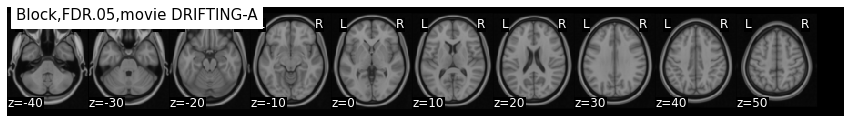

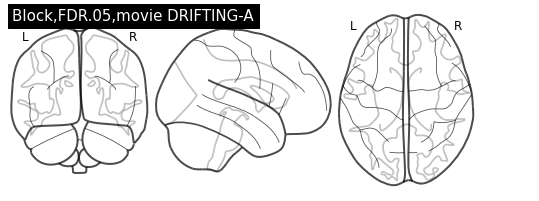

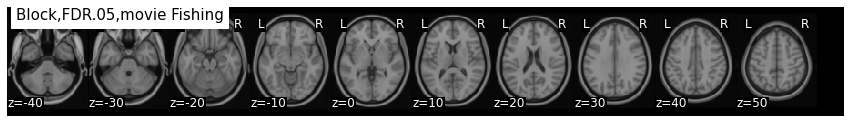

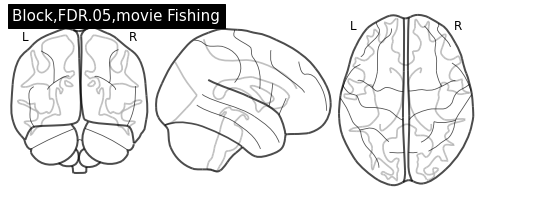

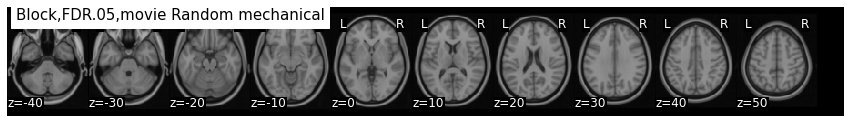

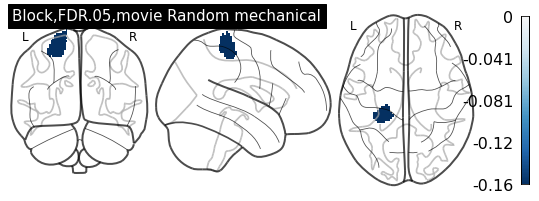

In [212]:
# separately for each movie

# block regressor

for i in range(len(movies_ind)):
    nodes = np.zeros((268,))
    nodes[p1[:,i]<.05] = mean_diff1[:,i][p1[:,i]<.05]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    txt = f'Block,FDR.05,movie {vid_joined[movies_ind[i]]}'
    img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
    plot_glass_brain(img.to_nifti(), colorbar = True, title =  txt,plot_abs=False, cmap = 'RdBu_r')
    #img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

    #rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block_bm<.05)[0]]
    #print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')

/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays.py:786: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


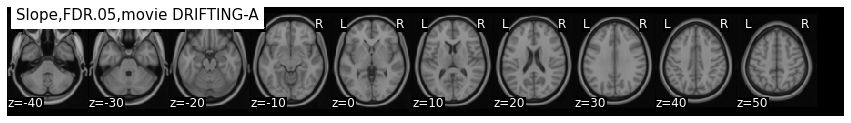

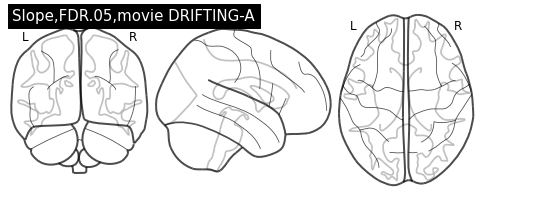

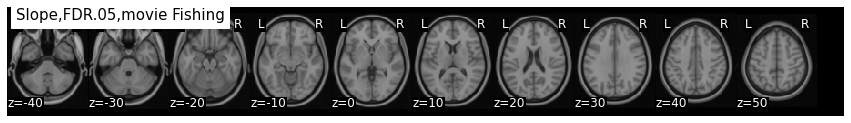

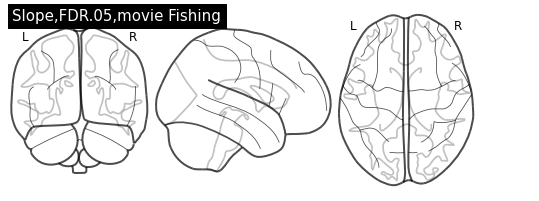

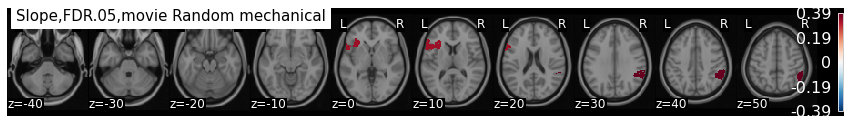

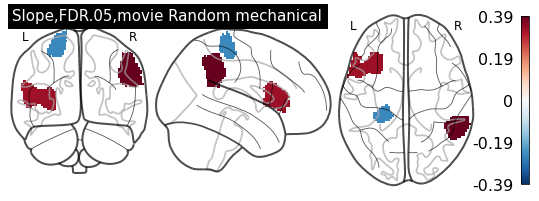

In [213]:
# separately for each movie

# slope regressor

for i in range(len(movies_ind)):
    nodes = np.zeros((268,))
    nodes[p2[:,i]<.05] = mean_diff2[:,i][p2[:,i]<.05]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    txt = f'Slope,FDR.05,movie {vid_joined[movies_ind[i]]}'
    img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
    plot_glass_brain(img.to_nifti(), colorbar = True, title =  txt,plot_abs=False, cmap = 'RdBu_r')
    #img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

    #rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block_bm<.05)[0]]
    #print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')

- looks like using the whole run to get movie-wise regressors yields fewer nodes - noisier results because of a larger baseline?
- either way, looks like we can stick to our original analysis selecting only the TRs before and after each video for the analysis

### COAX-BILL : Store block/slope regressors per run based on responses


0 time: 0.11898589134216309


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


100 time: 3.6764888763427734
200 time: 6.889337062835693
300 time: 10.505788803100586
400 time: 15.788915872573853
500 time: 20.85927700996399
600 time: 25.3250470161438
700 time: 29.77858591079712
800 time: 34.195513010025024
900 time: 38.46730089187622
1000 time: 42.67392706871033
done


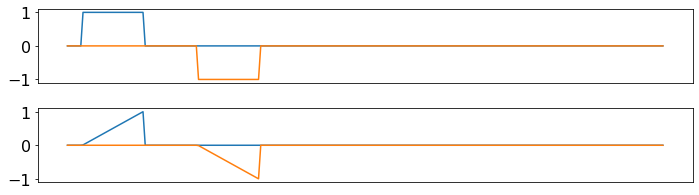

In [223]:
# coax_bill: Store block/slope regressors per run based on responses
movies_ind = [0,1]
coef_block_run1_coax_bill = np.empty((timecourses.shape[0],268))
coef_slope_run1_coax_bill = np.empty_like(coef_block_run1_coax_bill)
coef_block_run1_coax_bill[:] = np.nan
coef_slope_run1_coax_bill[:] = np.nan
start = time.time()
if __name__ == '__main__':
    pool = Pool(processes=cpu_count()) # helps to parallelize processing

    for s in range(timecourses.shape[0]):
        if s%100 ==0:
            print(s,'time:',time.time()-start) 
        
        if (responses[s,0] == 1) and (responses[s,1]==0):
        #if len(np.where(np.isnan(responses[s,:2]))[0]) == 0: # if the subject responded to coax and bill (excluding incomplete subs)
            for i,vid_no in enumerate(movies_ind):
                resp = responses[s,vid_no] # response for a subject and video nr.
                
                inds = timepts_indiv_movie[vid_no][vid_start_rel_tr[vid_no]:vid_start_rel_tr[vid_no]+l_task]
                
                boxcar_run = np.zeros((269,)) # to store runwise block regressors
                slope_run = np.zeros_like(boxcar_run) # to store runwise slope regressors
                
                if resp == 1:
                    boxcar_run[inds] = 1 
                    slope_run[inds] = np.linspace(0.01,1,len(inds)) 
                
                elif resp == 0:
                    boxcar_run[inds] = -1
                    slope_run[inds] = -1*np.linspace(0.01,1,len(inds))
                
                if (s==1):
                    plt.figure(1,figsize=(10,3))
                    plt.subplot(211)
                    plt.plot(boxcar_run, label = 'block reg')
                    plt.xticks([])
                    plt.subplot(212)
                    plt.plot(slope_run, label = 'slope reg')
                    plt.xticks([])
                    plt.tight_layout()

            
            Y = timecourses[s,:,:,0] # nodes * ntimepts
        
            XY = np.hstack((np.tile(boxcar_run,(268,1)),Y))
            #print(XY)
            XY = [ii for ii in XY]
            #X = boxcar_run[:,r].reshape((-1, 1))
            coef_block_run1_coax_bill[s,:] = pool.map(lm_estimate,XY)

            XY = np.hstack((np.tile(slope_run,(268,1)),Y))
            XY = [ii for ii in XY]
            coef_slope_run1_coax_bill[s,:] = pool.map(lm_estimate,XY)

print('done')

#### stats + plots

In [228]:
# separately for runs

p1 = np.empty((268,))
p2 = np.empty_like(p1)
p1[:] = np.nan
p2[:] = np.nan

for n in range(268):
    _,p1[n] = stats.ttest_1samp(coef_block_run1_coax_bill[:,n],0, nan_policy='omit')
    _,p2[n] = stats.ttest_1samp(coef_slope_run1_coax_bill[:,n],0, nan_policy='omit')
    
_,p1 = fdr_correction(p1,.05)
_,p2 = fdr_correction(p2,.05)



In [227]:
coef_block_run1_coax_bill.shape

(1048, 268)

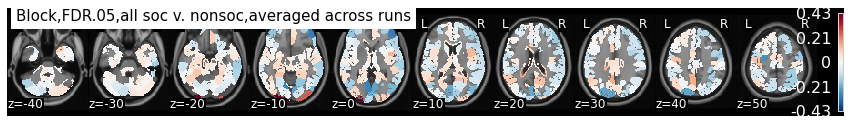

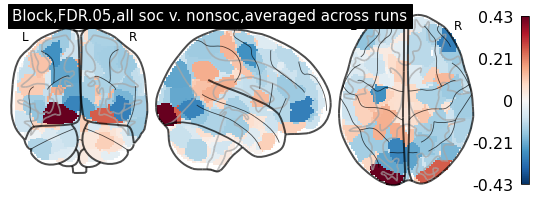

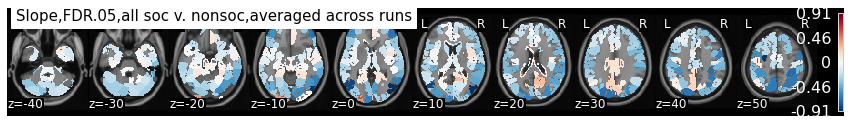

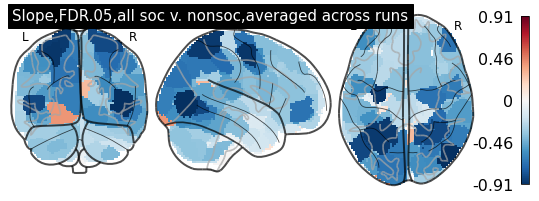

In [229]:
# block regressor, averaged across runs

nodes = np.zeros((268,))
nodes[p1_all<.05] = np.nanmean(coef_block_run1_coax_bill,axis=0)[p1_all<.05]
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = f'Block,FDR.05,all soc v. nonsoc,averaged across runs'
img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(), colorbar = True, title =  txt,plot_abs=False, cmap = 'RdBu_r')

# slope regressor, averaged across runs

nodes = np.zeros((268,))
nodes[p1_all<.05] = np.nanmean(coef_slope_run1_coax_bill,axis=0)[p1_all<.05]
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = f'Slope,FDR.05,all soc v. nonsoc,averaged across runs'
img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(), colorbar = True, title =  txt,plot_abs=False, cmap = 'RdBu_r')



- Lots of negative nodes - likely because mean activity went up over time from coax to bill. We effectively used runwise data whereas in the other analyses we used trialwise data